In [ ]:
%load_ext autoreload
%autoreload 2

In [3]:
#import sys
#!{sys.executable} -m pip install sagemaker -U
#!{sys.executable} -m pip install sagemaker-experiments

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import os
import sys
import time
import json
from IPython.display import display
from time import strftime, gmtime
import boto3
import re
from datetime import datetime

import sagemaker
from sagemaker import get_execution_role
from sagemaker.predictor import csv_serializer
from sagemaker.debugger import rule_configs, Rule, DebuggerHookConfig
from sagemaker.model_monitor import DataCaptureConfig, DatasetFormat, DefaultModelMonitor
from sagemaker.s3 import S3Uploader, S3Downloader

from smexperiments.experiment import Experiment
from smexperiments.trial import Trial
from smexperiments.trial_component import TrialComponent
from smexperiments.tracker import Tracker
from sklearn.model_selection import train_test_split

%cd /root/predicting-coronavirus
%pip install mpu
import src.data_import as di
#import src.data_tools as dt
import src.airport_index as ap

%matplotlib inline
pd.set_option('display.max_columns', 500)  
pd.set_option('display.max_rows', 500)   

/root/predicting-coronavirus
Note: you may need to restart the kernel to use updated packages.


In [5]:
sess = boto3.Session()
sm = sess.client('sagemaker')
role = sagemaker.get_execution_role()

In [7]:
!cd data/covid-19-data;git pull origin master

remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 15 (delta 9), reused 14 (delta 9), pack-reused 1
Unpacking objects: 100% (15/15), done.
From https://github.com/nytimes/covid-19-data
 * branch            master     -> FETCH_HEAD
   b761184..c95c96f  master     -> origin/master
Updating b761184..c95c96f
Fast-forward
 README.md            |   53 +-
 live/us-counties.csv | 2998 ++++++++++++++++++++++++++
 live/us-states.csv   |   56 +
 live/us.csv          |    2 +
 us-counties.csv      | 5841 +++++++++++++++++++++++++++++++++++++++++++++++++-
 us-states.csv        |  114 +-
 us.csv               |    4 +-
 7 files changed, 9054 insertions(+), 14 deletions(-)
 create mode 100644 live/us-counties.csv
 create mode 100644 live/us-states.csv
 create mode 100644 live/us.csv


In [6]:
account_id = sess.client('sts', region_name=sess.region_name).get_caller_identity()["Account"]
bucket = 'sagemaker-studio-{}-{}'.format(sess.region_name, account_id)
prefix = 'capstone2'

try:
    if sess.region_name == "us-east-1":
        sess.client('s3').create_bucket(Bucket=bucket)
    else:
        sess.client('s3').create_bucket(Bucket=bucket, 
                                        CreateBucketConfiguration={'LocationConstraint': sess.region_name})
except Exception as e:
    print("Looks like you already have a bucket of this name. That's good. Uploading the data files...")

# Return the URLs of the uploaded file, so they can be reviewed or used elsewhere
s3url = S3Uploader.upload('data/covid-19-data/us-counties.csv', 's3://{}/{}/{}'.format(bucket, prefix,'nyt'))
print(s3url)


s3://sagemaker-studio-us-east-1-752222400982/capstone2/nyt/us-counties.csv


In [ ]:
#etl = dt.etl()
#nyt = etl.load_nyt()
nyt = di.extract_nyt()

In [8]:
nyt_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 139802 entries, 0 to 141402
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    139802 non-null  datetime64[ns]
 1   county  139802 non-null  object        
 2   state   139802 non-null  object        
 3   fips    139802 non-null  int64         
 4   cases   139802 non-null  int64         
 5   deaths  139802 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 7.5+ MB


In [9]:
#Get the maximum cases and deaths for each fips
max_cases = nyt.groupby('fips').max()
max_cases = max_cases[['cases', 'deaths']]
#max_cases['deaths'].sum()
#max_cases

In [10]:
hhi = di.extract_hhi()
edu = di.extract_edu()
pubtrans = di.extract_public_transport()
housing = di.extract_housing()
election = di.extract_election()
geo = di.extract_geography()
counties = ap.extract_geography()
airports = ap.extract_airports()
intl_index = ap.build_intl_arrivals_index_df2(counties, airports, 30, 200)
sip = di.extract_sip()


INFO:numexpr.utils:NumExpr defaulting to 2 threads.
/root/predicting-coronavirus/src/data_import.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ret['hs'] = ret['hs']/100
/root/predicting-coronavirus/src/data_import.py:138: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ret['ba_plus'] = ret['ba_plus']/100
/root/predicting-coronavirus/src/data_import.py:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

<class 'pandas.core.series.Series'>


In [46]:
nyt = di.extract_nyt()

In [58]:
per100k = pd.merge(nyt, geo, how='inner', left_on=['fips'], right_on=['fips'])
per100k = per100k[['fips', 'state', 'population', 'date', 'cases', 'deaths']]
per100k['death_rate'] = per100k.apply(lambda row: (row['deaths']/row['population'])*100000, axis=1)
per100k['case_rate'] = per100k.apply(lambda row: (row['cases']/row['population'])*100000, axis=1)
per100k


,fips,state,population,date,cases,deaths,death_rate,case_rate
0,53061,Washington,713335,2020-01-21,1,0,0.0,0.140187
1,53061,Washington,713335,2020-01-22,1,0,0.0,0.140187
2,53061,Washington,713335,2020-01-23,1,0,0.0,0.140187
3,53061,Washington,713335,2020-01-24,1,0,0.0,0.140187
4,53061,Washington,713335,2020-01-25,1,0,0.0,0.140187
...,...,...,...,...,...,...,...,...
139797,31071,Nebraska,2049,2020-05-12,1,0,0.0,48.804295
139798,31071,Nebraska,2049,2020-05-13,1,0,0.0,48.804295
139799,17047,Illinois,6721,2020-05-13,2,0,0.0,29.757477
139800,19063,Iowa,10302,2020-05-13,1,0,0.0,9.706853


In [59]:
ten = per100k[per100k['case_rate'] > 10].groupby('fips').min()
ten = ten[['date']]
ten.columns = ['date_10']
#ten['date_10'].fillna(datetime(2020,5,15))

In [60]:
# Temportal stuff
ts_df = pd.merge(per100k, ten, how='left', left_on=['fips'], right_on=['fips'])
ts_df = pd.merge(ts_df, sip, how='left', left_on=['state'], right_on=['state'])


In [63]:
def days_since(row, calc_date):
    row['days_since_sip'] = int((calc_date - row['sip']).days)
    lifted = int((calc_date - row['sip_lifted']).days)
    if(lifted < 0):
        lifted = 0
    row['days_since_sip_lifted'] = lifted
    ten_per = row['date_10']
    if pd.isnull(ten_per):
        row['days_since_10p100k'] = 0
    else:
        row['days_since_10p100k'] = int((calc_date - ten_per).days)
    return row
ts_df['case_rate'] = ts_df['case_rate'].fillna(0)
ts_df['death_rate'] = ts_df['death_rate'].fillna(0)
ts_df = ts_df.apply(days_since, axis=1, args=[(datetime(2020,5,15))])


In [65]:
ts_df.to_csv('./data/ts_df.csv', header=False)


In [64]:
ts_df

,fips,state,population,date,cases,deaths,death_rate,case_rate,date_10,sip,sip_lifted,days_since_sip,days_since_sip_lifted,days_since_10p100k
0,53061,Washington,713335,2020-01-21,1,0,0.0,0.140187,2020-03-12,2020-03-23,2020-05-31,53,0,64
1,53061,Washington,713335,2020-01-22,1,0,0.0,0.140187,2020-03-12,2020-03-23,2020-05-31,53,0,64
2,53061,Washington,713335,2020-01-23,1,0,0.0,0.140187,2020-03-12,2020-03-23,2020-05-31,53,0,64
3,53061,Washington,713335,2020-01-24,1,0,0.0,0.140187,2020-03-12,2020-03-23,2020-05-31,53,0,64
4,53061,Washington,713335,2020-01-25,1,0,0.0,0.140187,2020-03-12,2020-03-23,2020-05-31,53,0,64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139797,31071,Nebraska,2049,2020-05-12,1,0,0.0,48.804295,2020-05-12,2020-05-15,2020-05-15,0,0,3
139798,31071,Nebraska,2049,2020-05-13,1,0,0.0,48.804295,2020-05-12,2020-05-15,2020-05-15,0,0,3
139799,17047,Illinois,6721,2020-05-13,2,0,0.0,29.757477,2020-05-13,2020-03-20,2020-05-29,56,0,2
139800,19063,Iowa,10302,2020-05-13,1,0,0.0,9.706853,NaT,2020-05-15,2020-05-15,0,0,0


In [66]:
# Geography and demographics
big_df = pd.merge(geo, hhi, how='inner', left_on=['fips'], right_on=['fips'])
big_df = pd.merge(big_df, edu, how='inner', left_on=['fips'], right_on=['fips'])
big_df = pd.merge(big_df, housing, how='inner', left_on=['fips'], right_on=['fips'])
big_df = pd.merge(big_df, pubtrans, how='inner', left_on=['fips'], right_on=['fips'])
big_df = pd.merge(big_df, election, how='left', left_on=['fips'], right_on=['fips'])
big_df = pd.merge(big_df, intl_index[['fips', 'international']], how='left', left_on=['fips'], right_on=['fips'])


In [67]:
big_df

,sc,fips,state,county,population,area-km,households,mean_hhi,median_hhi,pop_over_25,hs,ba_plus,ma_plus,pop_over_65,median_house_price,median_rent,percent_big_buildings,percent_commuter,per_dem,per_gop,international
0,Alabama:Baldwin,1003,Alabama,Baldwin,182265,4117.522,83501,56813,80251,155691,0.283,0.207,0.107,44443,193800,1057,0.141,0.0,0.195653,0.773515,1.000000e+00
1,Alabama:Calhoun,1015,Alabama,Calhoun,118572,1569.190,44264,45818,61117,79172,0.325,0.100,0.080,20515,121800,743,0.020,0.7,0.278559,0.692397,2.418858e+06
2,Alabama:Cullman,1043,Alabama,Cullman,80406,1903.228,30323,44612,67585,58319,0.311,0.084,0.037,15541,127700,710,0.008,0.0,0.100059,0.878105,1.000000e+00
3,Alabama:DeKalb,1049,Alabama,DeKalb,71109,2012.662,26462,36998,57354,48169,0.298,0.082,0.067,12261,112000,670,0.000,0.0,0.141149,0.834892,1.505138e+06
4,Alabama:Elmore,1051,Alabama,Elmore,79303,1601.868,30155,60796,70961,56793,0.325,0.179,0.074,12299,166300,837,0.002,0.0,0.228587,0.748381,7.020105e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
822,Wisconsin:Waukesha,55133,Wisconsin,Waukesha,389891,1423.389,158368,86968,115491,284512,0.221,0.295,0.161,75079,290500,1029,0.096,0.5,0.339516,0.610962,3.195409e+06
823,Wisconsin:Winnebago,55139,Wisconsin,Winnebago,166994,1125.316,71332,56589,75157,115949,0.326,0.183,0.069,27997,149200,735,0.067,0.5,0.431402,0.505833,2.330446e+04
824,Wisconsin:Wood,55141,Wisconsin,Wood,74749,2054.162,32274,55273,69755,52200,0.386,0.146,0.080,14940,129400,743,0.049,0.0,0.377387,0.570163,1.000000e+00
825,Wyoming:Laramie,56021,Wyoming,Laramie,91738,6956.480,39678,64306,84033,68017,0.286,0.177,0.087,16163,246500,893,0.058,0.0,0.289698,0.621955,2.970518e+05


In [75]:
big_df

,sc,fips,state,county,population,area-km,households,mean_hhi,median_hhi,pop_over_25,hs,ba_plus,ma_plus,pop_over_65,median_house_price,median_rent,percent_big_buildings,percent_commuter,per_dem,per_gop,international,percent_over_65,percent_over_25,pop_density,hh_density
0,Alabama:Baldwin,1003,Alabama,Baldwin,182265,4117.522,83501,56813,80251,155691,0.283,0.207,0.107,44443,193800,1057,0.141,0.0,0.195653,0.773515,1.000000e+00,0.243837,0.854201,44.265702,20.279430
1,Alabama:Calhoun,1015,Alabama,Calhoun,118572,1569.190,44264,45818,61117,79172,0.325,0.100,0.080,20515,121800,743,0.020,0.7,0.278559,0.692397,2.418858e+06,0.173017,0.667712,75.562551,28.208184
2,Alabama:Cullman,1043,Alabama,Cullman,80406,1903.228,30323,44612,67585,58319,0.311,0.084,0.037,15541,127700,710,0.008,0.0,0.100059,0.878105,1.000000e+00,0.193282,0.725307,42.247172,15.932405
3,Alabama:DeKalb,1049,Alabama,DeKalb,71109,2012.662,26462,36998,57354,48169,0.298,0.082,0.067,12261,112000,670,0.000,0.0,0.141149,0.834892,1.505138e+06,0.172425,0.677397,35.330821,13.147762
4,Alabama:Elmore,1051,Alabama,Elmore,79303,1601.868,30155,60796,70961,56793,0.325,0.179,0.074,12299,166300,837,0.002,0.0,0.228587,0.748381,7.020105e+04,0.155089,0.716152,49.506576,18.824897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
822,Wisconsin:Waukesha,55133,Wisconsin,Waukesha,389891,1423.389,158368,86968,115491,284512,0.221,0.295,0.161,75079,290500,1029,0.096,0.5,0.339516,0.610962,3.195409e+06,0.192564,0.729722,273.917390,111.261222
823,Wisconsin:Winnebago,55139,Wisconsin,Winnebago,166994,1125.316,71332,56589,75157,115949,0.326,0.183,0.069,27997,149200,735,0.067,0.5,0.431402,0.505833,2.330446e+04,0.167653,0.694330,148.397428,63.388417
824,Wisconsin:Wood,55141,Wisconsin,Wood,74749,2054.162,32274,55273,69755,52200,0.386,0.146,0.080,14940,129400,743,0.049,0.0,0.377387,0.570163,1.000000e+00,0.199869,0.698337,36.389048,15.711516
825,Wyoming:Laramie,56021,Wyoming,Laramie,91738,6956.480,39678,64306,84033,68017,0.286,0.177,0.087,16163,246500,893,0.058,0.0,0.289698,0.621955,2.970518e+05,0.176187,0.741427,13.187417,5.703747


In [72]:
big_df['percent_over_65'] = big_df['pop_over_65']/big_df['population']
big_df['percent_over_25'] = big_df['pop_over_25']/big_df['population']
big_df['pop_density'] = big_df['population']/big_df['area-km']
big_df['hh_density'] = big_df['households']/big_df['area-km']



demo_df = big_df.drop(['pop_over_65', 'pop_over_25', 'population', 'households','area-km'], axis=1)



In [1]:
final_df = pd.merge(ts_df, demo_df, how='inner', left_on=['fips'], right_on=['fips'])

NameError: name 'pd' is not defined

In [86]:
final_df = final_df[['fips',
                     #'date',
                     'death_rate',
                     'case_rate',
                     'days_since_sip',
                     'days_since_sip_lifted',
                     'days_since_10p100k',
                     'median_hhi',
                     'hs',
                     'ba_plus',
                     'ma_plus',
                     'median_house_price',
                     'median_rent',
                     'percent_big_buildings',
                     'percent_commuter',
                     'international',
                     'percent_over_65',
                     'pop_density',
                     'hh_density'
                    ]]

In [87]:
final_df

,fips,death_rate,case_rate,days_since_sip,days_since_sip_lifted,days_since_10p100k,median_hhi,hs,ba_plus,ma_plus,median_house_price,median_rent,percent_big_buildings,percent_commuter,international,percent_over_65,pop_density,hh_density
0,53061,0.0,0.140187,53,0,64,105073.0,0.234,0.221,0.106,455000.0,1525.0,0.091,5.9,1.742643e+06,0.154041,131.952143,55.533533
1,53061,0.0,0.140187,53,0,64,105073.0,0.234,0.221,0.106,455000.0,1525.0,0.091,5.9,1.742643e+06,0.154041,131.952143,55.533533
2,53061,0.0,0.140187,53,0,64,105073.0,0.234,0.221,0.106,455000.0,1525.0,0.091,5.9,1.742643e+06,0.154041,131.952143,55.533533
3,53061,0.0,0.140187,53,0,64,105073.0,0.234,0.221,0.106,455000.0,1525.0,0.091,5.9,1.742643e+06,0.154041,131.952143,55.533533
4,53061,0.0,0.140187,53,0,64,105073.0,0.234,0.221,0.106,455000.0,1525.0,0.091,5.9,1.742643e+06,0.154041,131.952143,55.533533
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139797,31071,0.0,48.804295,0,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
139798,31071,0.0,48.804295,0,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
139799,17047,0.0,29.757477,56,0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
139800,19063,0.0,9.706853,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [88]:
save_df = final_df.drop(['death_rate', 'fips'], axis=1).set_index('case_rate')
save_trainval, save_test = train_test_split(save_df) 
save_train, save_val = train_test_split(save_trainval) 

save_train.to_csv('./data/train2.csv', header=False)
save_val.to_csv('./data/val2.csv', header=False)
save_test.to_csv('./data/test2.csv', header=False)
save_df.to_csv('./data/merged2.csv')

In [22]:
y = clean_df['case_rate']
X = clean_df.drop(['case_rate', 'death_rate', 'sc', 'state', 'county'], axis=1).set_index('fips')


In [23]:
X['days_since_sip'].describe()

count    827.000000
mean      47.690447
std       10.543738
min        0.000000
25%       44.000000
50%       49.000000
75%       54.000000
max       57.000000
Name: days_since_sip, dtype: float64

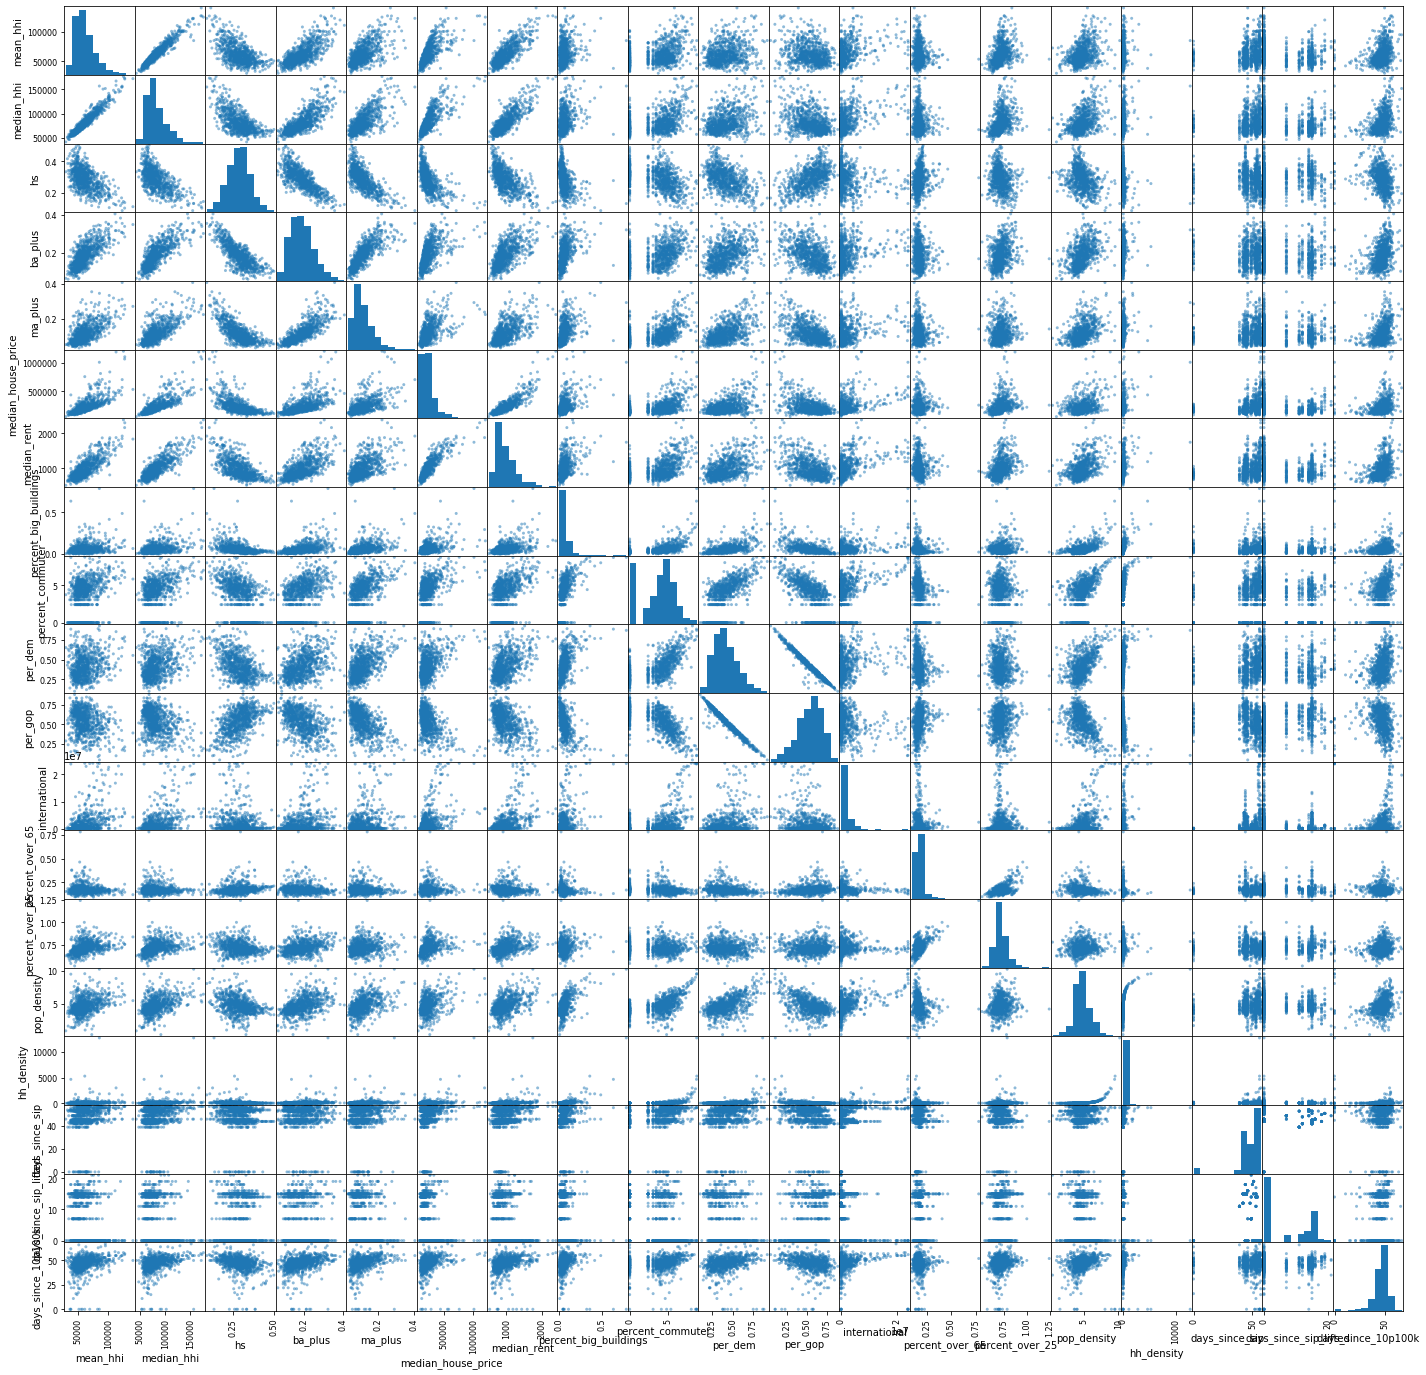

In [287]:
#X = X[['days_since_10p100k', 'days_since_sip_lifted', 'days_since_sip', 'pop_density', 'percent_commuter']]
#X = X[['pop_density']
#per100k['cases_per'] = per100k.apply(lambda row: (row['cases']/row['population'])*100000, axis=1)

#X['days_since_sip'] = X.apply(lambda x: np.log(x['days_since_sip']*100+1), axis=1)
X['percent_commuter'] = X.apply(lambda x: np.log(x['percent_commuter']*100+1), axis=1)
X['pop_density'] = X.apply(lambda x: np.log(x['pop_density']), axis=1)
xxx = pd.plotting.scatter_matrix(X, figsize=(24,24))

In [195]:
X.describe()

,pop_density,percent_commuter
count,827.000000,827.000000
mean,310.514600,2.102056
std,1262.104736,5.538989
min,1.396347,0.000000
25%,51.393694,0.100000
50%,97.232984,0.700000
75%,207.641479,1.800000
max,26821.922674,60.700000


Mean cross-validation score: 0.35


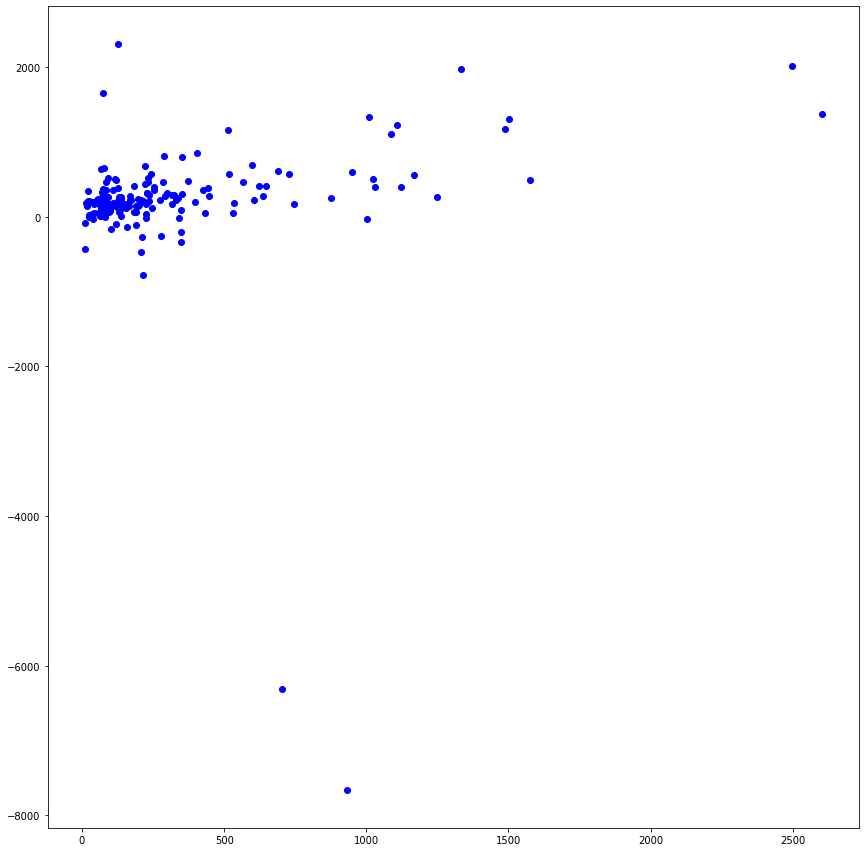

In [24]:
from sklearn.linear_model import LinearRegression 
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score, KFold

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
poly.fit(X_train_poly, y_train)
lin = LinearRegression()
lin.fit(X_train_poly, y_train)
X_test_poly = poly.fit_transform(X_test)
predicted = lin.predict(X_test_poly)

fig, ax = plt.subplots(figsize=(12,12))
fig.tight_layout()
plt.scatter(y_test, predicted, color = 'blue', label="actual data") 
#lin.score(X_train_poly, y_train)
#lin.score(X_test_poly, y_test)
scores = cross_val_score(lin, X_train,y_train, cv=5)
print("Mean cross-validation score: %.2f" % scores.mean())

In [25]:
rms = sqrt(mean_squared_error(y_test, predicted))
rms

NameError: name 'sqrt' is not defined

In [27]:
#%pip install xgboost
import xgboost as xgb

In [28]:
xgbr = xgb.XGBRegressor() 
print(xgbr)

XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             objective='reg:squarederror', random_state=None, reg_alpha=None,
             reg_lambda=None, scale_pos_weight=None, subsample=None,
             tree_method=None, validate_parameters=False, verbosity=None)


In [29]:
xgbr.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

Mean cross-validation score: 0.34


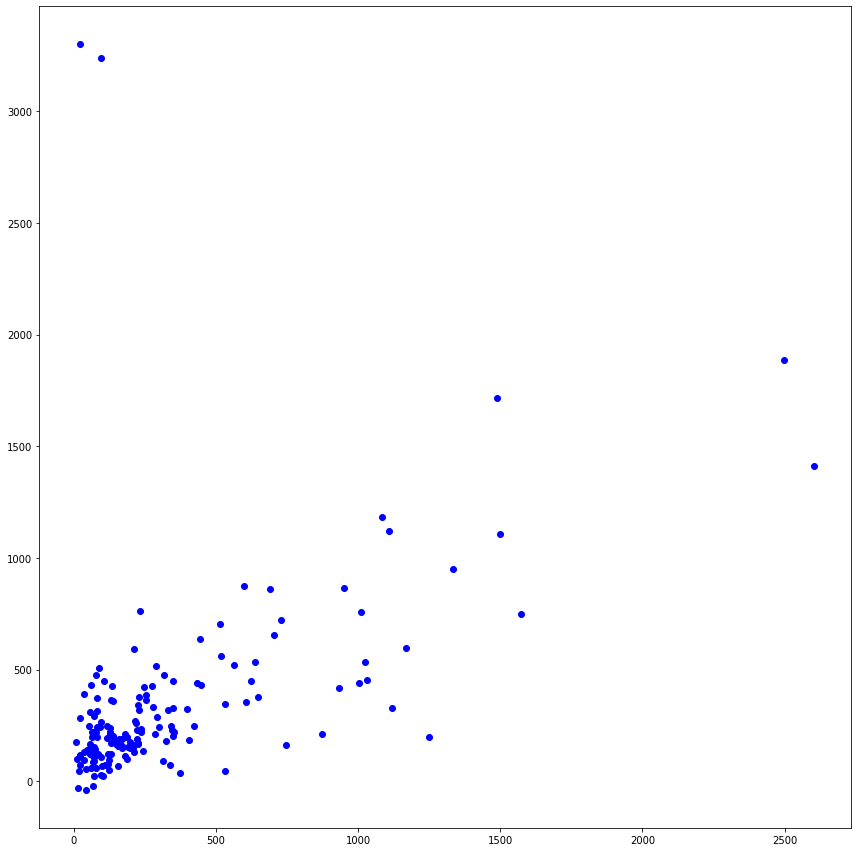

In [30]:
predicted = xgbr.predict(X_test)
fig, ax = plt.subplots(figsize=(12,12))
fig.tight_layout()
plt.scatter(y_test, predicted, color = 'blue', label="actual data") 
#lin.score(X_train_poly, y_train)
#lin.score(X_test_poly, y_test)
scores = cross_val_score(xgbr, X_train, y_train, cv=5)

print("Mean cross-validation score: %.2f" % scores.mean())

In [26]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(y_test, predicted))
rms

942.0358113040417

In [42]:
dumb = np.full(len(y_test), np.mean(y_test))
sqrt(mean_squared_error(y_test, dumb))

411.37044331270266

In [293]:
y.describe()

count     827.000000
mean      297.587130
std       427.774475
min         0.000000
25%        82.204788
50%       163.425530
75%       320.521947
max      4005.300189
Name: case_rate, dtype: float64